# Simple Wave and Wind Hybrid Plant Example
---
In this example, we will walk through the process of simulating a hybrid renewable energy system including both wave and wind energy.

### Import Required Modules
We start by importing the necessary modules and setting up our working environment.

In [1]:
from hopp import ROOT_DIR
from hopp.simulation.technologies.sites import SiteInfo, oahu_site
from hopp.utilities import load_yaml
from hopp.simulation import HoppInterface
from hopp.utilities.keys import set_nrel_key_dot_env
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

c:\Users\jmartin4\Documents\Code\jmartin4nrel\HOPP-NREL\examples\log\hybrid_systems_2024-02-07T17.41.16.540764.log


### Set API Key
To access the Wind Toolkit (wind resource) and NSRDB (solar resource) data, we need to set an API key. You can obtain an API key from the [NREL developer website](https://developer.nrel.gov/signup/).

To set up the `NREL_API_KEY` required for resource downloads, you can create an Environment Variable called `NREL_API_KEY`. Otherwise, you can keep the key in a new file called ".env" in the root directory of this project.

Create a file ".env" that contains the single line:
`NREL_API_KEY=key`

In [2]:
# Set API key using the .env
set_nrel_key_dot_env()

#### (Optional)

This step is if you do not set the API key using a ".env" file.

In [3]:
import os
from hopp.utilities.keys import set_developer_nrel_gov_key

# Set API key manually if not using the .env
global NREL_API_KEY
NREL_API_KEY = os.getenv("NREL_API_KEY") # Set this key manually here if you are not setting it using the .env
set_developer_nrel_gov_key(NREL_API_KEY)  

### Set electrolyzer load
Set the desired load schedule to control the battery dispatch

In [4]:
DEFAULT_SOLAR_RESOURCE_FILE = ROOT_DIR.parent / "examples" / "inputs" / "resource_files" / "eco" / "oahu_N_19_18_loop_solar_resource.csv"
DEFAULT_WIND_RESOURCE_FILE = ROOT_DIR.parent / "examples" / "inputs" / "resource_files" / "eco" / "oahu_N_19_18_loop_wind_resource_srw.srw"
DEFAULT_WAVE_RESOURCE_FILE = ROOT_DIR.parent / "examples" / "inputs" / "resource_files" / "eco" / "oahu_N_19_18_loop_wave_resource_3hr.csv"
DEFAULT_PRICE_FILE = ROOT_DIR.parent / "resource_files" / "grid" / "pricing-data-2015-IronMtn-002_factors.csv"
elzyer_load_kw = float(250 * 1000)
DEFAULT_LOAD = elzyer_load_kw*np.ones((8760))/1000

site = SiteInfo(
        oahu_site,
        solar_resource_file=DEFAULT_SOLAR_RESOURCE_FILE,
        wind_resource_file=DEFAULT_WIND_RESOURCE_FILE,
        wave_resource_file=DEFAULT_WAVE_RESOURCE_FILE,
        grid_resource_file=DEFAULT_PRICE_FILE,
        desired_schedule=DEFAULT_LOAD,
        solar=True,
        wind=True,
        wave=True
    )

### Create the HOPP Model
To generate the HOPP Model, instantiate the `HoppInterface` class and supply the required YAML configuration with the technology configuration and site information.

For the site information, the wind/wave/solar resource data from Oahu have been saved under examples/inputs/resource_files/eco

The Wave technology configuration requires the, device rating (kw), wave power matrix and number of devices.

Note that the wave model doesn't come with a default financial model. To address this, you must establish the `CustomFinancialModel` from HOPP.

The `default_fin_config` contains all of the necessary parameters for the financial calculations.

To maintain consistency across technologies, apply the `default_fin_config` to each technology configuration. This ensures that all technologies use the same financial model throughout the HOPP Model.

In [5]:
hopp_config = load_yaml("./inputs/08-eco.yaml")
# set SiteInfo instance
hopp_config["site"] = site
hi = HoppInterface(hopp_config)

### Enter turbine power curve and eliminate losses

In [6]:
wind_power_curve = ROOT_DIR.parent / "examples" / "inputs" / "resource_files" / "eco" / "iea15mw_power_curve.csv"
curve_data = pd.read_csv(wind_power_curve)
wind_speed = curve_data['Wind Speed [m/s]'].values.tolist() 
curve_power = [i*1000 for i in curve_data['Power [MW]']]
hi.system.wind._system_model.Turbine.wind_turbine_powercurve_windspeeds = wind_speed
hi.system.wind._system_model.Turbine.wind_turbine_powercurve_powerout = curve_power 

all_losses = 0.0
loss_list = ["avail_bop_loss","avail_grid_loss","avail_turb_loss","elec_eff_loss","elec_parasitic_loss","env_degrad_loss", "env_env_loss", "env_icing_loss", "ops_env_loss", "ops_grid_loss", "ops_load_loss", "turb_generic_loss", "turb_hysteresis_loss", "turb_perf_loss", "turb_specific_loss", "wake_ext_loss"]
for loss in loss_list:
    getattr(hi.system, 'wind').value(loss,all_losses)

### Add Wave Cost Model Inputs
Add the inputs to run the wave technology cost model and instantiate `MHKCosts`.

In [7]:
cost_model_inputs = {
	'reference_model_num':3,
	'water_depth': 100,
	'distance_to_shore': 80,
	'number_rows': 10,
	'device_spacing':600,
	'row_spacing': 600,
	'cable_system_overbuild': 20
}
hi.system.wave.create_mhk_cost_calculator(cost_model_inputs)

### Run the Simulation
Simulate the hybrid renewable energy system for a specified number of years (in this case, 1 year).

In [8]:
hi.simulate(1)

Simulating system with dispatch optimization...
Number of periods to optimize: 1
	 0 % complete


### Retrieve and Display Results
Access the simulation results and print them to the console.

(17901.583333333332, 17902.583333333332)

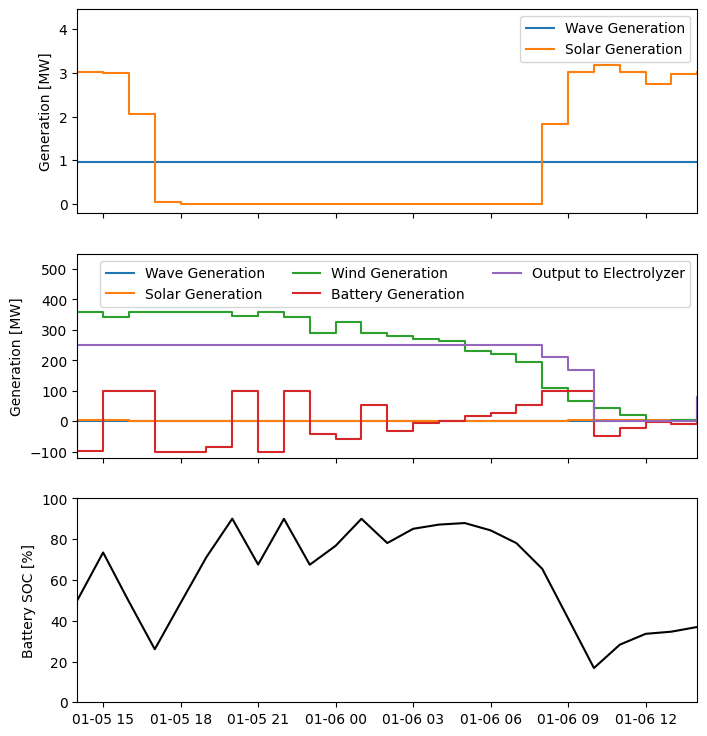

In [15]:
hybrid_plant = hi.system
gen = hybrid_plant.generation_profile
batt = hybrid_plant.battery.outputs

# Make time series - "hopp_time" with one point per hour, "hopp_time2" with two points per hour
hopp_time = pd.date_range('2019-01-01', periods=8761, freq='1 h')
hopp_time2 = np.vstack([hopp_time,hopp_time])
hopp_time2 = np.reshape(np.transpose(hopp_time2),8761*2)
hopp_time2 = hopp_time2[1:-1]
hopp_time = hopp_time[:-1]

# Get generation of all generators as objects
wind_gen = np.array(gen['wind'])
wave_gen = np.array(gen['wave'])
pv_gen = np.array(gen['pv'])
batt_gen = np.array(gen['battery'])
hybrid_gen = np.array(gen['hybrid'])

# Double up the generation timepoints to make stepped plot with hopp_time2
gen2_list = ["wind_gen2", "wave_gen2", "pv_gen2", "batt_gen2", "hybrid_gen2"]
for i, gen1 in enumerate([wind_gen, wave_gen, pv_gen, batt_gen, hybrid_gen]):
    gen2 = np.vstack([gen1,gen1])
    gen2 = np.reshape(np.transpose(gen2),8760*2)
    exec(gen2_list[i]+" = gen2")

# Fill out the battery SOC time history
batt_soc = np.array(batt.SOC)
batt_soc[1:] = batt_soc[:-1]
batt_soc[:111] = 50
batt_soc[134:] = batt_soc[134]

# Plot results
fig,ax=plt.subplots(3,1,sharex=True)
fig.set_figwidth(8.0)
fig.set_figheight(9.0)

ax[0].plot(hopp_time2,wave_gen2/1000,label="Wave Generation")
ax[0].plot(hopp_time2,pv_gen2/1000,label="Solar Generation")
ax[0].legend()
ax[0].set_ylabel('Generation [MW]')

ax[1].plot(hopp_time2,wave_gen2/1000,label="Wave Generation")
ax[1].plot(hopp_time2,pv_gen2/1000,label="Solar Generation")
ax[1].plot(hopp_time2,wind_gen2/1000,label="Wind Generation")
ax[1].plot(hopp_time2,batt_gen2/1000,label="Battery Generation")
ax[1].plot(hopp_time2,hybrid_gen2/1000,label="Output to Electrolyzer")
ax[1].legend(ncol=3)
ax[1].set_ylabel('Generation [MW]')
ax[1].set_ylim([-120,550])


ax[2].plot(hopp_time,batt_soc,'k-')
ax[2].set_ylabel('Battery SOC [%]')
ax[2].set_ylim([0,100])

sim_start = '2019-01-05 14:00'
sim_end = '2019-01-06 14:00'
plt.xlim(pd.DatetimeIndex((sim_start,sim_end)))

### Interpolate between hourly points to make placeholder ARIES signals

(340.0, 380.0)

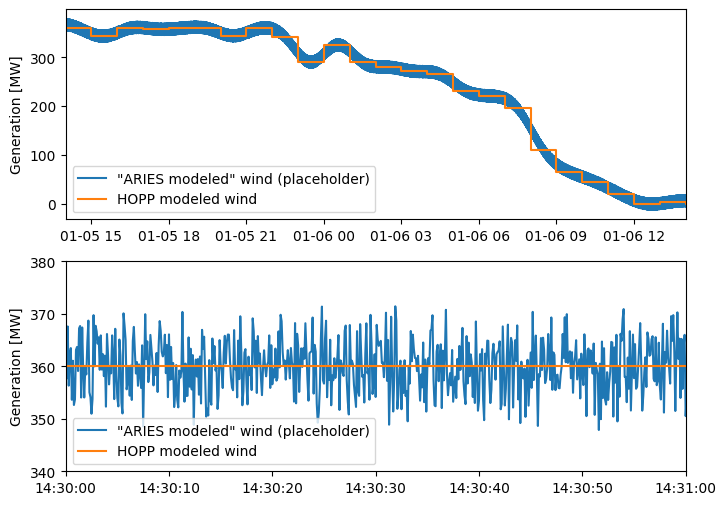

In [14]:
# Interpolate the HOPP generation to 100 ms intervals
hopp_time3 = pd.date_range('2019-01-01 00:30', periods=8760, freq='1 h')
gen_frame = pd.DataFrame(np.transpose([wind_gen, wave_gen, pv_gen]),index=hopp_time3, columns=['wind','wave','solar'])
slice_start = '2019-01-05 13:00'
slice_end = '2019-01-06 15:00'
gen_frame2 = gen_frame[slice_start:slice_end]
gen_frame3 = gen_frame2.resample('100 ms').interpolate('cubic')

# Superimpose some random noise
for tech in gen_frame3.columns.values:
    values = gen_frame3[tech].values
    mean = np.mean(values)
    gen_frame3[tech] = values+np.random.rand(len(values))*mean/20-np.random.rand(len(values))*mean/20

hopp_time3 = gen_frame3.index.values
wind_gen3 = gen_frame3['wind'].values

fig,ax=plt.subplots(2,1)
fig.set_figwidth(8.0)
fig.set_figheight(6.0)

ax[0].plot(hopp_time3,wind_gen3/1000,label = '"ARIES modeled" wind (placeholder)')
ax[0].plot(hopp_time2,wind_gen2/1000,label = 'HOPP modeled wind')
ax[0].set_xlim(pd.DatetimeIndex((sim_start,sim_end)))
ax[0].legend()
ax[0].set_ylabel('Generation [MW]')

zoom_start = '2019-01-05 14:30'
zoom_end = '2019-01-05 14:31'
ax[1].plot(hopp_time3,wind_gen3/1000,label = '"ARIES modeled" wind (placeholder)')
ax[1].plot(hopp_time2,wind_gen2/1000,label = 'HOPP modeled wind')
ax[1].set_xlim(pd.DatetimeIndex((zoom_start,zoom_end)))
ax[1].legend()
ax[1].set_ylabel('Generation [MW]')
ax[1].set_ylim([340,380])